In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix 
import numpy as np
import joblib
import warnings
import matplotlib.pyplot as plt 
import seaborn as sns 

%matplotlib inline

warnings.filterwarnings('ignore')

## 1. Data Loading

In [2]:
df = pd.read_csv('D:\Tugas Akhir\A_dataset_pengajuan_bpjs_dengan_status.csv', delimiter=';')

In [3]:
df.shape

(10000, 65)

In [4]:
df.head()

,KODE_RS,KELAS_RS,KELAS_RAWAT,KODE_TARIF,PTD,ADMISSION_DATE,DISCHARGE_DATE,BIRTH_DATE,BIRTH_WEIGHT,SEX,...,KAMAR_AKOMODASI,RAWAT_INTENSIF,OBAT,ALKES,BMHP,SEWA_ALAT,OBAT_KRONIS,OBAT_KEMO,NAMA_FILE,status
0,2071034,B,3,BP,2,2024-03-18 00:00:00,2024-03-18 00:00:00,2022-07-15 00:00:00,0,2,...,0,0,15382,38254,32825,0,0,0,RJTL MARET 2024 DETAIL.TXT,1
1,2071034,B,3,BP,2,2024-05-07 00:00:00,2024-05-07 00:00:00,1967-04-12 00:00:00,0,2,...,0,0,210019,0,0,0,0,0,RJTL MEI 2024 DETAIL.TXT,1
2,2071034,B,3,BP,2,2024-02-19 00:00:00,2024-02-19 00:00:00,1973-06-08 00:00:00,0,1,...,0,0,409013,0,43000,0,0,0,RJTL FEBRUARI 2024 DETAIL.TXT,1
3,2071034,B,3,BP,1,2024-01-03 00:00:00,2024-01-05 00:00:00,1977-08-13 00:00:00,0,2,...,518430,0,156134,237650,92516,0,0,0,RITL JANUARI 2024 DETAIL.TXT,1
4,2071034,B,3,BP,1,2024-04-01 00:00:00,2024-04-04 00:00:00,1974-06-07 00:00:00,0,1,...,2670949,0,695699,178873,6577154,0,0,0,4. RITL REVISI APRIL 2024 DETAIL.TXT,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 65 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   KODE_RS             10000 non-null  int64 
 1   KELAS_RS            10000 non-null  object
 2   KELAS_RAWAT         10000 non-null  int64 
 3   KODE_TARIF          10000 non-null  object
 4   PTD                 10000 non-null  int64 
 5   ADMISSION_DATE      10000 non-null  object
 6   DISCHARGE_DATE      10000 non-null  object
 7   BIRTH_DATE          10000 non-null  object
 8   BIRTH_WEIGHT        10000 non-null  int64 
 9   SEX                 10000 non-null  int64 
 10  DISCHARGE_STATUS    10000 non-null  int64 
 11  DIAGLIST            10000 non-null  object
 12  PROCLIST            10000 non-null  object
 13  ADL1                10000 non-null  object
 14  ADL2                10000 non-null  object
 15  INACBG              10000 non-null  object
 16  DESKRIPSI_INACBG    100

## 2. Data Preprocessing

In [6]:
object_columns = df.select_dtypes(include='object').columns
print("Kolom dengan tipe data 'object':")
print(object_columns)

Kolom dengan tipe data 'object':
Index(['KELAS_RS', 'KODE_TARIF', 'ADMISSION_DATE', 'DISCHARGE_DATE',
       'BIRTH_DATE', 'DIAGLIST', 'PROCLIST', 'ADL1', 'ADL2', 'INACBG',
       'DESKRIPSI_INACBG', 'DESKRIPSI_SP', 'DESKRIPSI_SR', 'DESKRIPSI_SI',
       'DESKRIPSI_SD', 'SEP', 'PAYOR_ID', 'VERSI_INACBG', 'C2', 'C4',
       'NAMA_FILE'],
      dtype='object')


In [7]:
# Konversi kolom kategorikal menjadi numerik dengan one-hot encoding
categorical_cols = ["KELAS_RS", "ADL1", "ADL2", "PAYOR_ID"]
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Konversi kolom tanggal menjadi bertipe data datetime dan hitung fitur tambahan yang relevan
df["ADMISSION_DATE"] = pd.to_datetime(df["ADMISSION_DATE"])
df["DISCHARGE_DATE"] = pd.to_datetime(df["DISCHARGE_DATE"])
df["BIRTH_DATE"] = pd.to_datetime(df["BIRTH_DATE"])

df["LOS_CALCULATED"] = (df["DISCHARGE_DATE"] - df["ADMISSION_DATE"]).dt.days
df["AGE_AT_ADMISSION"] = (df["ADMISSION_DATE"] - df["BIRTH_DATE"]).dt.days / 365.25

# Handle kolom 'VERSI_INACBG', sesuaikan format desimalnya
df['VERSI_INACBG'] = df['VERSI_INACBG'].str.replace(',', '.', regex=False).astype(float)

# Hapus kolom yang tidak relevan untuk user input
columns_to_drop = [
    "KODE_RS", "KODE_TARIF", "PTD", #dihapus karena merupakan ID unik
    "INACBG", "DESKRIPSI_INACBG", "DESKRIPSI_SP", "DESKRIPSI_SR", "DESKRIPSI_SI", "DESKRIPSI_SD",
    "NAMA_FILE", "ADMISSION_DATE", "DISCHARGE_DATE", "BIRTH_DATE", #dihapus karena informasi sudah diekstrak
    "SEP", "C1", "C2", "C3", "C4", "DIAGLIST", "PROCLIST"
]

df = df.drop(columns=columns_to_drop, errors="ignore")

# Identifikasi kolom numerik yang memiliki nilai kosong
numeric_cols = df.select_dtypes(include=np.number).columns
for col in numeric_cols:
    if df[col].isnull().any():
        if df[col].dtype == np.int64:
            df[col] = df[col].astype(float)
        df[col] = df[col].fillna(df[col].median())

# Memastikan tidak ada kolom 'object'. Jika ada, hapus
for col in df.select_dtypes(include='object').columns:
    df = df.drop(columns=[col])

print("Preprocessing selesai. Berikut informasi data terkini")
df.info()

Preprocessing selesai. Berikut informasi data terkini
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 44 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   KELAS_RAWAT         10000 non-null  int64  
 1   BIRTH_WEIGHT        10000 non-null  int64  
 2   SEX                 10000 non-null  int64  
 3   DISCHARGE_STATUS    10000 non-null  int64  
 4   TARIF_INACBG        10000 non-null  int64  
 5   TARIF_SUBACUTE      10000 non-null  int64  
 6   TARIF_CHRONIC       10000 non-null  int64  
 7   TARIF_SP            10000 non-null  int64  
 8   TARIF_SR            10000 non-null  int64  
 9   TARIF_SI            10000 non-null  int64  
 10  TARIF_SD            10000 non-null  int64  
 11  TOTAL_TARIF         10000 non-null  int64  
 12  TARIF_RS            10000 non-null  int64  
 13  TARIF_POLI_EKS      10000 non-null  int64  
 14  LOS                 10000 non-null  int64  
 15  

## 3. Feature and Target Split

In [8]:
X = df.drop(columns=["status", "TARIF_RS"], errors='ignore')
y = df["status"]

X = X.select_dtypes(include=np.number)


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [10]:
X_train.shape, X_test.shape

((8000, 41), (2000, 41))

In [11]:
X_test.dtypes

KELAS_RAWAT             int64
BIRTH_WEIGHT            int64
SEX                     int64
DISCHARGE_STATUS        int64
TARIF_INACBG            int64
TARIF_SUBACUTE          int64
TARIF_CHRONIC           int64
TARIF_SP                int64
TARIF_SR                int64
TARIF_SI                int64
TARIF_SD                int64
TOTAL_TARIF             int64
TARIF_POLI_EKS          int64
LOS                     int64
ICU_INDIKATOR           int64
ICU_LOS                 int64
VENT_HOUR               int64
UMUR_TAHUN              int64
UMUR_HARI               int64
VERSI_INACBG          float64
VERSI_GROUPER           int64
PROSEDUR_NON_BEDAH      int64
PROSEDUR_BEDAH          int64
KONSULTASI              int64
TENAGA_AHLI             int64
KEPERAWATAN             int64
PENUNJANG               int64
RADIOLOGI               int64
LABORATORIUM            int64
PELAYANAN_DARAH         int64
REHABILITASI            int64
KAMAR_AKOMODASI         int64
RAWAT_INTENSIF          int64
OBAT      

In [12]:
X_train.dtypes

KELAS_RAWAT             int64
BIRTH_WEIGHT            int64
SEX                     int64
DISCHARGE_STATUS        int64
TARIF_INACBG            int64
TARIF_SUBACUTE          int64
TARIF_CHRONIC           int64
TARIF_SP                int64
TARIF_SR                int64
TARIF_SI                int64
TARIF_SD                int64
TOTAL_TARIF             int64
TARIF_POLI_EKS          int64
LOS                     int64
ICU_INDIKATOR           int64
ICU_LOS                 int64
VENT_HOUR               int64
UMUR_TAHUN              int64
UMUR_HARI               int64
VERSI_INACBG          float64
VERSI_GROUPER           int64
PROSEDUR_NON_BEDAH      int64
PROSEDUR_BEDAH          int64
KONSULTASI              int64
TENAGA_AHLI             int64
KEPERAWATAN             int64
PENUNJANG               int64
RADIOLOGI               int64
LABORATORIUM            int64
PELAYANAN_DARAH         int64
REHABILITASI            int64
KAMAR_AKOMODASI         int64
RAWAT_INTENSIF          int64
OBAT      

In [13]:
X_train.head()

,KELAS_RAWAT,BIRTH_WEIGHT,SEX,DISCHARGE_STATUS,TARIF_INACBG,TARIF_SUBACUTE,TARIF_CHRONIC,TARIF_SP,TARIF_SR,TARIF_SI,...,KAMAR_AKOMODASI,RAWAT_INTENSIF,OBAT,ALKES,BMHP,SEWA_ALAT,OBAT_KRONIS,OBAT_KEMO,LOS_CALCULATED,AGE_AT_ADMISSION
9254,3,0,1,1,201500,0,0,0,0,0,...,0,0,850519,0,0,0,0,6081,0,42.956879
1561,3,0,2,1,251900,0,0,0,0,0,...,0,0,0,0,52500,0,0,0,0,24.572211
1670,3,0,2,1,201500,0,0,0,0,0,...,0,0,465845,0,0,0,0,0,0,33.210130
6087,1,0,2,1,11542100,0,0,0,0,0,...,3060290,0,287638,100968,2206390,0,0,0,3,43.115674
6669,3,0,1,1,921300,0,0,0,0,0,...,0,0,0,0,696229,0,0,0,0,49.700205


## 4. Model Classification Training

In [14]:
# impor Random Forest classifier
from sklearn.ensemble import RandomForestClassifier

# inisiasi classifier 
rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# latih model
rfc.fit(X_train, y_train)

# prediksi hasil test
y_pred = rfc.predict(X_test)

# Nilai akurasi

from sklearn.metrics import accuracy_score
print('Nilai akurasi dengan 10 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Nilai akurasi dengan 10 decision-trees : 0.8520


In [15]:
# inisiasi classifier dengan n_estimators = 100
rfc_100 = RandomForestClassifier(n_estimators=100, random_state=0)

# latih model
rfc_100.fit(X_train, y_train)

# prediksi hasil test
y_pred_100 = rfc_100.predict(X_test)

print('Nilai akurasi dengan 100 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred_100)))

Nilai akurasi dengan 100 decision-trees : 0.8525


In [16]:
# inisiasi classifier dengan n_estimators = 100
rfc_500 = RandomForestClassifier(n_estimators=500, random_state=0)

# latih model
rfc_500.fit(X_train, y_train)

# prediksi hasil test
y_pred_500 = rfc_500.predict(X_test)

print('Nilai akurasi dengan 500 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred_500)))

Nilai akurasi dengan 500 decision-trees : 0.8515


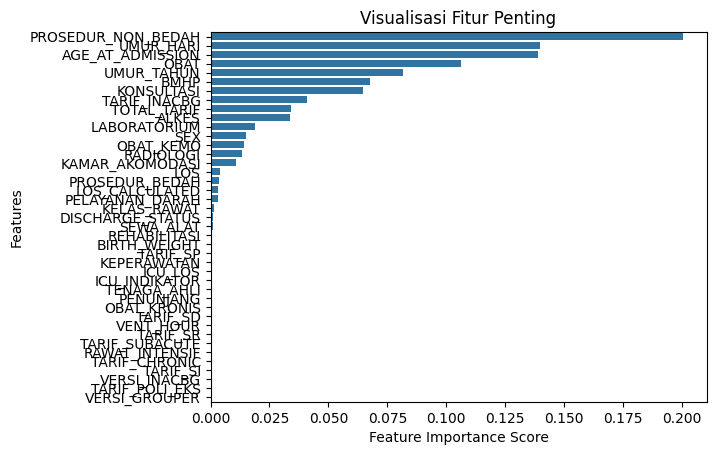

In [17]:
feature_scores = pd.Series(rfc_100.feature_importances_, index=X_train.columns).sort_values(ascending=False)

sns.barplot(x=feature_scores, y=feature_scores.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualisasi Fitur Penting")

plt.show()

In [18]:
feature_names_list = feature_scores.index.tolist()
feature_importance_values_list = feature_scores.values.tolist()

# Mencetak hasilnya
print("Nama Fitur (diurutkan berdasarkan kepentingan):")
print(feature_names_list)
print("\nSkor Kepentingan Fitur (numerik):")
print(feature_importance_values_list)

# Jika Anda ingin melihatnya sebagai pasangan key-value (dictionary):
feature_importance_dict = feature_scores.to_dict()
print("\nSkor Kepentingan Fitur (dalam bentuk Dictionary):")
print(feature_importance_dict)

# Atau, jika Anda ingin menampilkannya sebagai tabel yang lebih rapi (tanpa visualisasi plot)
print("\nFitur dan Skor Kepentingan (Tabel):")
print(feature_scores)

Nama Fitur (diurutkan berdasarkan kepentingan):
['PROSEDUR_NON_BEDAH', 'UMUR_HARI', 'AGE_AT_ADMISSION', 'OBAT', 'UMUR_TAHUN', 'BMHP', 'KONSULTASI', 'TARIF_INACBG', 'TOTAL_TARIF', 'ALKES', 'LABORATORIUM', 'SEX', 'OBAT_KEMO', 'RADIOLOGI', 'KAMAR_AKOMODASI', 'LOS', 'PROSEDUR_BEDAH', 'LOS_CALCULATED', 'PELAYANAN_DARAH', 'KELAS_RAWAT', 'DISCHARGE_STATUS', 'SEWA_ALAT', 'REHABILITASI', 'BIRTH_WEIGHT', 'TARIF_SP', 'KEPERAWATAN', 'ICU_LOS', 'ICU_INDIKATOR', 'TENAGA_AHLI', 'PENUNJANG', 'OBAT_KRONIS', 'TARIF_SD', 'VENT_HOUR', 'TARIF_SR', 'TARIF_SUBACUTE', 'RAWAT_INTENSIF', 'TARIF_CHRONIC', 'TARIF_SI', 'VERSI_INACBG', 'TARIF_POLI_EKS', 'VERSI_GROUPER']

Skor Kepentingan Fitur (numerik):
[0.20034084124777327, 0.13956667331674139, 0.13894035171722022, 0.10606254799605024, 0.08171795725401494, 0.06773616682372716, 0.06469253576815329, 0.04083096024140984, 0.03431903559588637, 0.03363531720467421, 0.019058428783495462, 0.01522415372732481, 0.01428317085170302, 0.013488704757400296, 0.01099457024830426

## 5. Model Evaluation

Akurasi Model Classifier: 0.8525
Presisi Model Classifier: 0.8567
Recall Model Classifier: 0.9794
F1-Score Model Classifier: 0.9139


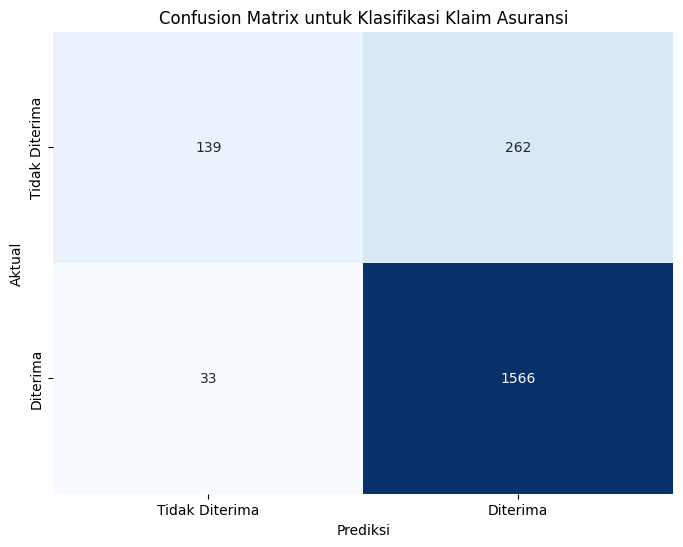

In [19]:
y_clf_pred = rfc_100.predict(X_test)

accuracy = accuracy_score(y_test, y_clf_pred)
precision = precision_score(y_test, y_clf_pred, average='binary')
recall = recall_score(y_test, y_clf_pred, average='binary')
f1 = f1_score(y_test, y_clf_pred, average='binary')

print(f"Akurasi Model Classifier: {accuracy:.4f}")
print(f"Presisi Model Classifier: {precision:.4f}")
print(f"Recall Model Classifier: {recall:.4f}")
print(f"F1-Score Model Classifier: {f1:.4f}")

# Menampilkan Confusion Matrix
cm = confusion_matrix(y_test, y_clf_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Tidak Diterima', 'Diterima'],
            yticklabels=['Tidak Diterima', 'Diterima'])
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix untuk Klasifikasi Klaim Asuransi')
plt.show()

## 6. Save Model and Feature Columns

In [20]:
joblib.dump(rfc, 'C_classifier_model.pkl')
joblib.dump(X.columns.tolist(), 'C_feature_columns.pkl')
print("Model classifier dan feature columns disimpan.")

Model classifier dan feature columns disimpan.
